The code below converts the 3D annotations bounding boxes from the NuScenes dataset from a specific sensor to the 2D Yolo format

The code was also inspired by the work done in https://github.com/asvath/mobile_robotics

In [1]:
#Initializing the libraries to be used on the code

import numpy as np #The numpy is used in several libraries from the NuScene devkit
import matplotlib as plt #The matplot lib is used in the Nuscene devkit as well. This line below renders the function in the jupyter notebook
%matplotlib inline

"""
Importing the NuScenes devkit with all of the libraries used. 
More information can be found in https://github.com/nutonomy/nuscenes-devkit
"""

from nuscenes.nuscenes import NuScenes, NuScenesExplorer

#Pay attention that I've donwloaded the complete version of the data set
nusc = NuScenes(version='v1.0-trainval', dataroot= r'D:\Meus_documentos\Mestrado\Teste dataset', verbose=True)

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 126.274 seconds.
Reverse indexing ...
Done reverse indexing in 50.0 seconds.


***
The NuScenes dataset has several tables in a python dictionary structure,
which can be visualized in https://www.nuscenes.org/nuscenes 

***
The database schema is visualized below. For more information see the [nuScenes schema](https://github.com/nutonomy/nuscenes-devkit/blob/master/docs/schema_nuscenes.md) page.
![](https://www.nuscenes.org/public/images/nuscenes-schema.svg)

In [2]:
#To list the categories and its statistics
print (nusc.list_categories())


Category stats for split v1.0-trainval:
animal                      n=  787, width= 0.37±0.13, len= 0.86±0.36, height= 0.60±0.20, lw_aspect= 2.35±0.69
human.pedestrian.adult      n=208240, width= 0.67±0.13, len= 0.73±0.19, height= 1.77±0.18, lw_aspect= 1.11±0.26
human.pedestrian.child      n= 2066, width= 0.51±0.14, len= 0.53±0.15, height= 1.38±0.25, lw_aspect= 1.05±0.23
human.pedestrian.constructi n= 9161, width= 0.72±0.20, len= 0.71±0.20, height= 1.74±0.30, lw_aspect= 1.02±0.29
human.pedestrian.personal_m n=  395, width= 0.62±0.12, len= 1.18±0.31, height= 1.71±0.27, lw_aspect= 1.98±0.64
human.pedestrian.police_off n=  727, width= 0.73±0.14, len= 0.69±0.13, height= 1.83±0.14, lw_aspect= 0.97±0.18
human.pedestrian.stroller   n= 1072, width= 0.63±0.13, len= 0.95±0.27, height= 1.17±0.15, lw_aspect= 1.58±0.68
human.pedestrian.wheelchair n=  503, width= 0.77±0.10, len= 1.09±0.23, height= 1.37±0.09, lw_aspect= 1.42±0.23
movable_object.barrier      n=152087, width= 2.53±0.64, len= 0.50±0.17,

Since NuScenes have several categories we will merge some categories in order to have just three of them

*Pedestrians* = human.pedestrian.adult + human.pedestrian.child + human.pedestrian.construction_worker + human.pedestrian.police_officer.


*Objects* = movable_object.barrier + movable_object.debris + movable_object.pushable_pullable + movable_object.trafficcone

*Vehicles* = vehicle.bicycle + vehicle.bus.bendy + vehicle.bus.rigid + vehicle.car + vehicle.construction + vehicle.motorcycle + vehicle.trailer + vehicle.truck


In [3]:
classes = ['human.pedestrian.adult','human.pedestrian.child','human.pedestrian.construction_worker','human.pedestrian.police_officer','movable_object.barrier', 'movable_object.debris','movable_object.pushable_pullable', 'movable_object.trafficcone','vehicle.bicycle', 'vehicle.bus.bendy', 'vehicle.bus.rigid','vehicle.car','vehicle.construction','vehicle.motorcycle','vehicle.trailer', 'vehicle.truck']

pedestrians = ['human.pedestrian.adult','human.pedestrian.child','human.pedestrian.construction_worker','human.pedestrian.police_officer']

objects = ['movable_object.barrier', 'movable_object.debris','movable_object.pushable_pullable', 'movable_object.trafficcone']

vehicles = ['vehicle.bicycle', 'vehicle.bus.bendy', 'vehicle.bus.rigid','vehicle.car','vehicle.construction','vehicle.motorcycle','vehicle.trailer', 'vehicle.truck']

In [4]:
#classes = ['human.pedestrian.adult', 'human.pedestrian.child','human.pedestrian.police_officer','human.pedestrian.construction_worker','vehicle.car','vehicle.bicycle']
#pedestrians = ['human.pedestrian.adult', 'human.pedestrian.child','human.pedestrian.police_officer','human.pedestrian.construction_worker'] 

In [5]:
#Besides the categories themselves the NuScene data set also have the attributes of the istances (objects/things) annotated
#Up to now this information will not be used

nusc.list_attributes()

cycle.with_rider: 7331
cycle.without_rider: 17345
pedestrian.moving: 157444
pedestrian.sitting_lying_down: 13939
pedestrian.standing: 46530
vehicle.moving: 149203
vehicle.parked: 420226
vehicle.stopped: 65975


The NuScene has an specific sensor suit which can be visualized in the figure below
For the deep fusion that will be done in the vehicle at beginning just the CAM Front and the RADAR Front will be used

![](NuScene_Sensors.png)

In [6]:
#We access the sensor suit and its Tokens with the line below

nusc.sensor

[{'token': '725903f5b62f56118f4094b46a4470d8',
  'channel': 'CAM_FRONT',
  'modality': 'camera'},
 {'token': 'ce89d4f3050b5892b33b3d328c5e82a3',
  'channel': 'CAM_BACK',
  'modality': 'camera'},
 {'token': 'a89643a5de885c6486df2232dc954da2',
  'channel': 'CAM_BACK_LEFT',
  'modality': 'camera'},
 {'token': 'ec4b5d41840a509984f7ec36419d4c09',
  'channel': 'CAM_FRONT_LEFT',
  'modality': 'camera'},
 {'token': '2f7ad058f1ac5557bf321c7543758f43',
  'channel': 'CAM_FRONT_RIGHT',
  'modality': 'camera'},
 {'token': 'ca7dba2ec9f95951bbe67246f7f2c3f7',
  'channel': 'CAM_BACK_RIGHT',
  'modality': 'camera'},
 {'token': 'dc8b396651c05aedbb9cdaae573bb567',
  'channel': 'LIDAR_TOP',
  'modality': 'lidar'},
 {'token': '47fcd48f71d75e0da5c8c1704a9bfe0a',
  'channel': 'RADAR_FRONT',
  'modality': 'radar'},
 {'token': '232a6c4dc628532e81de1c57120876e9',
  'channel': 'RADAR_FRONT_RIGHT',
  'modality': 'radar'},
 {'token': '1f69f87a4e175e5ba1d03e2e6d9bcd27',
  'channel': 'RADAR_FRONT_LEFT',
  'modality'

In [7]:
#The NuScenes database works with Scenes the complete data base has 1000 scenes with 20 seconds of duration each
#The "Mini" data set contains 10 scenes as show below

For each scene the database has annotations for every 0,5 second (2Hz)
For the "mini" database we can say that for 10 scenes with 20 seconds of duration each with 0,5 seconds of annotation we have an average of 400 samples let's check this in the line below

In [8]:
#print(len(nusc.sample)) #The calculus matches

total_no_of_samples = len(nusc.sample)

print('total number of samples', total_no_of_samples)

total number of samples 34149


In [9]:
#My intention is to convert only the images collected by the front camera and not from the whole sensor suit
#A simple function from NuScenes does the work, to collect the "tokens" only for a specfic sensor data from all 404 samples

def specific_sensor_data(sensor_type):
    sample_data_camera_tokens = [s['token'] for s in nusc.sample_data if (s['channel'] == 'CAM_FRONT') and
                                 s['is_key_frame']]
    return sample_data_camera_tokens

In [10]:
sensor_type = "CAM_FRONT"
sensor_tokens = specific_sensor_data(sensor_type)
sensor_tokens

['6ff2a727cdd447c5956582f420c5a80c',
 '020d7b4f858147558106c504f7f31bef',
 '8d9b8b382be84198841f9409d7d38557',
 '27460c51459c46a6b8a94525793ff813',
 'f1826933e09349c0bb5606bd3555cb43',
 '5af8e4f03044406a9abd5bffd940952a',
 'd3c1ddf65b0c4e43955ec56f447022fb',
 '58d25273f5cd4c1fa3b4caf38ec21ee2',
 '7ad5d6b946ec4c8daf9ce2938e419ba7',
 'bf22e1dfe3c340879a22a428103ed16a',
 'cc4b920cf112459d95ef548982954b00',
 'e783540996ba4627a224f6600370a4e7',
 'b6b19a64f93e4cda8aa00c68dcf660ac',
 '31386ace672c4b819d13cfe1fd937e7a',
 'ca07b31b3972420a8a96df006c3626a4',
 '3c85a2dbb49f4e97972baa2d7fb43a9c',
 'ff5614a913024a11a34d05aa9dbdbd62',
 'a59c061fc9b7488693b91d0bab13acf1',
 'fab51dc7b3204b399b3cd819dac91791',
 '8ac67041c264432a8d6999b290fd1d51',
 'b274269af6a94949bc4d63bbf1cc6bcc',
 'cbd3813834474e9f9cb1b34bc4a82208',
 '4a64e30267874f579a61cce64eb792d0',
 'fc194824e095410ab0d5bc90943b2429',
 '0053f3138b1e469e838c82c4c1c0596e',
 'e873f794c06540549eb72758345f8483',
 'c19272651a3b4fc094eb70a1c50e0edd',
 

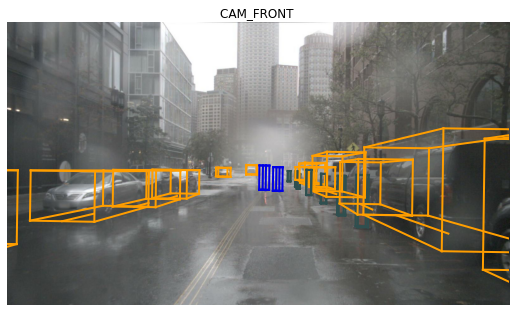

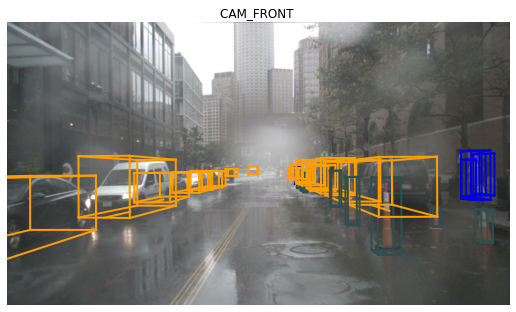

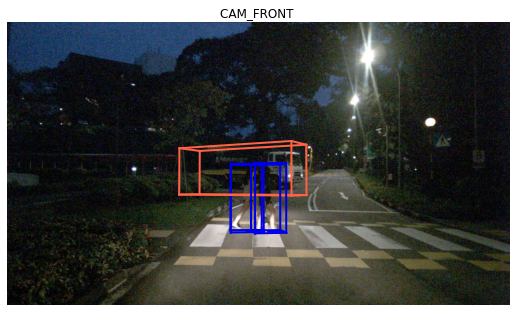

In [16]:
#Verifying if the code works rendering some of them

nusc.render_sample_data(sensor_tokens[27291])

nusc.render_sample_data(sensor_tokens[27295])

nusc.render_sample_data(sensor_tokens[30728])

In [17]:
print(len(sensor_tokens))

34149


In [18]:
"""
Using the NuScene function below we can see that the information comes from the samples
The bounding boxes are transformed into the current sensor's coordinate frame

"""

#teste_1 = nusc.get_sample_data(sensor_tokens[300])
#teste_1

"\nUsing the NuScene function below we can see that the information comes from the samples\nThe bounding boxes are transformed into the current sensor's coordinate frame\n\n"


Inspired in the work done in https://github.com/asvath/mobile_robotics

We will collect the bounding boxes and convert the camera coordinates to the image coordinates utilizing the

intrisic camera calibration matrices.

The idea is to get 2D bounding boxes for objects with visibility is higher than 40% and whose the center fall within the image

boundaries.






**The first thing that the aformentioned work does is to change to edit get_sample_data from the nutomy's original code**
**I will rename this for get_sample_data_mod**

get_sample_data_mod

input:(nusc, sample_data_token)

output: path to the data, lists of 3d bounding boxes in the image (in camera coordinates),
annotation token of annotation in the image, intrisic matrix of the camera)



In [19]:
from pyquaternion import Quaternion #This is one way of representing 3D objects mathematically
from pyquaternion.quaternion import Quaternion
from nuscenes.utils.data_classes import Box #This class within the NuScene represent the 3D bounding boxes
from nuscenes.utils.geometry_utils import Quaternion, box_in_image, BoxVisibility
import numpy as np
"""
The method box_in_image checks if a box is visible inside an image without accounting for occlusions and returns true if 
the visibility condition is satisfied

The method BoxVisibility enumerates the various level of box visibility in an image

ALL = 0 #Requires all corners are inside the image.
ANY = 1 #Requires at least one corner visible in the image.
NONE = 2 #Requires no corner to be inside, i.e box can be fully outside the image.

"""

from nuscenes.utils.geometry_utils import box_in_image, BoxVisibility

#Initializing our Get_sample_data_mod function:

def get_sample_data_mod(nusc_object, sample_data_token, box_vis_level = BoxVisibility.ANY, selected_anntokens = None):
    
    #It initiates as the original get_sample_data function retriving the sensor & pose records
    #Pay attention that instead of self for the classes we are using the "nusc_object"
    
    sd_record = nusc_object.get('sample_data', sample_data_token)
    cs_record = nusc_object.get('calibrated_sensor', sd_record['calibrated_sensor_token'])
    sensor_record = nusc_object.get('sensor', cs_record['sensor_token'])
    pose_record = nusc_object.get('ego_pose', sd_record['ego_pose_token'])
    
    #This specific line below is new in this situation we gate also the sample token
    sample_record = nusc_object.get('sample',sd_record['sample_token'])
    
    
    #From this line the code is similar to the original one
    data_path = nusc_object.get_sample_data_path(sample_data_token)
    
    #Verifying the sensor modality if it is a camera to retrieve the coordinates
    if sensor_record['modality'] == 'camera':
        #In the line below if it is a camera the coordinates in saved in a numpy array
        cam_intrinsic = np.array(cs_record['camera_intrinsic'])
        #Getting the image size
        imsize = (sd_record['width'], sd_record['height'])
    else:
        cam_intrinsic = None
        imsize = None
       
    #As in the original function the "if" part below retrieve all sample annotation and map to sensor coordinate system.
    if selected_anntokens is not None:
        boxes = list(map(nusc_object.get_box, selected_anntokens))
    else:
        boxes = nusc_object.get_boxes(sample_data_token)
        selected_anntokens = sample_record['anns']
            
    #Make a list of Box objects including coordinate system transforms.
    
    box_list = []
    
    #In our case we will also do the annotation list
    
    ann_list = []
    
    for box,ann in zip(boxes,selected_anntokens):  #The zip functions interacts in tuples
        
        #move box to ego vehicle coordinate system
        box.translate(-np.array(pose_record['translation']))
        box.rotate(Quaternion(pose_record['rotation']).inverse)
        
        #  Move box to sensor coord system
        box.translate(-np.array(cs_record['translation']))
        box.rotate(Quaternion(cs_record['rotation']).inverse)
        
        
        #Pay attention on the box_in_image which will verify if a box is visible inside an image without accounting for occlusions
        if sensor_record['modality'] == 'camera' and not \
                box_in_image(box, cam_intrinsic, imsize, vis_level=box_vis_level):
            continue

        box_list.append(box)
        ann_list.append(ann)
    
    #this is for a single sample image
    return data_path, box_list, ann_list, cam_intrinsic #single image infon
        
        
        
        

The next function is also from  https://github.com/asvath/mobile_robotics 

Which transform the 3D bounding boxes in 2D bounding boxes

threeD_to_2D function

input: (box(camera coordinates), intrisic matrix))
output: corners of the 2D bouding box in image plane

In [20]:
#Lets test what we did in the functions above

#evaluation1 = get_sample_data_mod(nusc,sensor_tokens[300])
#evaluation1

#print(sensor_tokens[300])

In [21]:
def threeD_2_twoD(boxsy, intrinsic): #Input is a single annotation box
    
    """
    given annotation boxes and intrinsic camera matrix
    outputs the 2d bounding box coordinates as a list (all annotation for a particular saple image)
    
    """
    corners = boxsy.corners()
    x = corners[0,:]
    y = corners[1,:]
    z = corners[2,:]
    x_y_z = np.array((x,y,z))
    orthographic = np.dot(intrinsic,x_y_z)
    perspective_x = orthographic[0]/orthographic[2]
    perspective_y = orthographic[1]/orthographic[2]
    perspective_z = orthographic[2]/orthographic[2]
    
    min_x = np.min(perspective_x)
    max_x = np.max(perspective_x)
    min_y = np.min(perspective_y)
    max_y = np.max(perspective_y)
    

    
    return min_x,max_x,min_y,max_y

The next function is intended to transform the 3D bounding boxes in 2D bouding boxes to all samples annotations

The code was also taken from: https://github.com/asvath/mobile_robotics

all_3d_to_2d(boxes, anns, intrinsic)

input: boxes in camera coordinates,list of annotation tokens of annotation in the image, intrinsic matrix

output: x_min, x_max, y_min, y_max, width, height of the 2D bounding boxes of objects that are more than 40% visible in panoramic view of all cameras, also ensures that the center of the bounding boxes falls inside the image

In [22]:
classes = ['human.pedestrian.adult','human.pedestrian.child','human.pedestrian.construction_worker','human.pedestrian.police_officer','vehicle.bicycle', 'vehicle.bus.bendy', 'vehicle.bus.rigid','vehicle.car','vehicle.construction','vehicle.motorcycle','vehicle.trailer', 'vehicle.truck']

pedestrians = ['human.pedestrian.adult','human.pedestrian.child','human.pedestrian.construction_worker','human.pedestrian.police_officer']

#objects = ['movable_object.barrier', 'movable_object.debris','movable_object.pushable_pullable', 'movable_object.trafficcone']

vehicles = ['vehicle.bicycle', 'vehicle.bus.bendy', 'vehicle.bus.rigid','vehicle.car','vehicle.construction','vehicle.motorcycle','vehicle.trailer', 'vehicle.truck']

In [23]:
def all_3d_to_2d(boxes,anns,intrinsic): #input 3d boxes, annotation key lists, intrinsic matrix (one image)
    x_min=[]
    x_max=[]
    y_min=[]
    y_max =[]
    width=[]
    height=[]
    objects_detected =[]
    orig_objects_detected =[]
    
   
    for j in range(len(boxes)): #iterate through boxes
        box=boxes[j]
        
        if box.name in classes: #if the box.name is in the classes we want to detect
        
            if box.name in pedestrians: 
                orig_objects_detected.append("pedestrian")
            #elif box.name in objects: 
                #orig_objects_detected.append("object")
            else:
                orig_objects_detected.append("vehicle")
            #print(box)
            
            #if box.name in pedestrians: 
                #orig_objects_detected.append("pedestrian")
            #elif box.name == "vehicle.car":
                #orig_objects_detected.append("car")
            #else:
                #orig_objects_detected.append("cyclist")
            
            visibility = nusc.get('sample_annotation', '%s' %anns[j])['visibility_token'] #give annotation key
            visibility = int(visibility)

            
            if visibility > 1: #more than 40% visible in the panoramic view of the the cameras

                    
                center = box.center #get boxe's center

                center = np.dot(intrinsic,center)
                center_point = center/(center[2]) #convert center point into image plane
                
                
                
                
                if center_point[0] <-100 or center_point[0] > 1700 or center_point[1] <-100 or center_point[1] >1000:
                    #if center of bounding box is outside of the image, do not annotate
                    pass
                
                else:
                    min_x, max_x, min_y, max_y = threeD_2_twoD(box,intrinsic) #converts box into image plane
                    w = max_x - min_x
                    h = max_y - min_y
        
        
                    x_min.append(min_x)
                    x_max.append(max_x)
                    y_min.append(min_y)
                    y_max.append(max_y)
                    width.append(w)
                    height.append(h)
                    if box.name in pedestrians: 
                        objects_detected.append("pedestrian")
                    #elif box.name in objects: 
                        #orig_objects_detected.append("object")
                    else:
                        objects_detected.append("vehicle")
                    

            else:
                pass

    return x_min,x_max,y_min,y_max,width,height,objects_detected,orig_objects_detected #for a single image

The last function is intended to extract the 2d bounding boxes

extract_bounding_box(i camera_name):

input: sample number i, camera_name

ouput: min_x, max_x, min_y, max_y, width and height of bounding box in image coordinates 2d bounding box of objects which are 40% bisible in panoramic view of all cameras and center falls within the image

In [24]:
def extract_bounding_box(i, camera_name): #give a single sample number and the camera name
    
    """
    input: sample number i, camera name
    
    outputs: min_x, max_x, min_y, max_y, width and height of bouding box in image coordinates of 2D bouding boxe.
    
    Options for camera name: CAM_FRONT, CAM_FRONT_RIGHT, CAM_FRONT_LEFT, CAM_BACK, CAM_BACK_RIGHT, CAM_BACK_LEFT
    
    """
    
    nusc.sample[i] #one image
    
    camera_token = nusc.sample[i]['data']['%s' %camera_name]#one camera, get the camera token
    
    path, boxes, anns, intrinsic_matrix = get_sample_data_mod(nusc, '%s' %camera_token) #gets data for one image
    
    x_min, x_max, y_min, y_max, width, height, objects_detected, orig_objects_detected = all_3d_to_2d(boxes,anns,intrinsic_matrix)
    
    return x_min, x_max, y_min, y_max, width, height, path, boxes, intrinsic_matrix, objects_detected, orig_objects_detected

    #info for a single image

The next function creates a target directory to place the new 2d bouding boxes annotation


In [25]:
import os.path

def create_annotation_directory(camera):
    current_dir = os.getcwd()
    #current_dir = '%/annotation' %pwd
    
    dirName = "%s/annotation/%s_anno" %(current_dir, camera)
    if not os.path.exists(dirName):
        os.makedirs(dirName)
        print("Directory ", dirName , " Created")
        
    else:
        print("Directory ", dirName, "already exists")

The next function creates the annotations in XML file

In [26]:
from lxml import etree as ET
def write_xml_annotation(x_min,x_max,y_min,y_max,width,height,path,boxes,objects_detected): #single image info
    #detected_items =[]
    #import xml.etree.cElementTree as ET
    path_split = path.split("/")
    full_image_name = path_split[-1]
    name =full_image_name.split(".")[0]
    
    root = ET.Element("annotation")


    ET.SubElement(root, "folder").text = "%s" %camera
    ET.SubElement(root, "filename").text = "%s" %full_image_name
    ET.SubElement(root, "path").text = "%s" %path

    source = ET.SubElement(root, "source")
    ET.SubElement(source, "database").text = "nuTonomy-nuscenes"

    size = ET.SubElement(root, "size")
    ET.SubElement(size, "width").text="1600"
    ET.SubElement(size,"height").text="900"
    ET.SubElement(size,"depth").text="3"
    ET.SubElement(root, "segmented").text = "0"

    for j in range(len(objects_detected)): #
        
        flag_x = 0
        flag_y = 0
        
        ob= ET.SubElement(root, "object")
        ET.SubElement(ob,"name").text="%s" %objects_detected[j]
        ET.SubElement(ob,"pose").text="Unspecified"
        
        
        '''
        write out truncated boxes
        '''
        
        if x_min[j] < 0:
            x_minsy = 0
            flag_x =1
            
        else:
            x_minsy = x_min[j]
            
        if y_min[j] <0:
            y_minsy = 0
            flag_y =1
            
        else:
            y_minsy = y_min[j]
            
        if x_max[j] > 1600:
            x_maxsy = 1600
            flag_x = 1
            
        else:
            x_maxsy = x_max[j]
            
        if y_max[j] >900:
            y_maxsy = 900
            flag_y = 1
            
        else:
            y_maxsy = y_max[j]
            
            
        if flag_x == 1 or flag_y ==1:
            ET.SubElement(ob, "truncated").text="1"
            
        else:
            ET.SubElement(ob, "truncated").text="0"
            
            
        
        
        ET.SubElement(ob, "difficult").text="0"

        bb = ET.SubElement(ob,"bndbox")
        
        
        ET.SubElement(bb,"xmin").text="%s" %x_minsy
        ET.SubElement(bb,"ymin").text="%s" %y_minsy
        ET.SubElement(bb,"xmax").text="%s" %x_maxsy
        ET.SubElement(bb,"ymax").text="%s" %y_maxsy
        
 
    filename = "%s/%s.xml" %(dirName,name)
    tree = ET.ElementTree(root)
    #tree.write("%s/%s.xml" %(dirName,name),pretty_print=True)
    tree.write("%s" %filename, pretty_print=True)
    
    return filename #file a single file
    
    

In [27]:
camera_names =['CAM_FRONT']

i = 0
detected_items =[]
orig_detected_items=[]
obs = []

file=[]

for camera in camera_names: #iterate through all cameras
    print(camera)
    create_annotation_directory(camera)
    current_dir =os.getcwd()
    dirName ="%s/annotation/%s_anno" %(current_dir,camera) #current directory's name
    #we are looking at one camera now
    for sample_number in range(total_no_of_samples):#look at a single image
        #print(sample_number)
        #get in for a single image
        
        
        
        
        x_min, x_max,y_min,y_max,width,height, path, boxes, intrinsic_matrix,objects_detected,orig_objects_detected = extract_bounding_box(sample_number, '%s' %camera) 
        write_xml_annotation(x_min,x_max,y_min,y_max,width,height,path,boxes,objects_detected)
        
   
        

CAM_FRONT
Directory  D:\Meus_documentos\Mestrado\Códigos python\01 - 3D_bounding_boxes_to_2D/annotation/CAM_FRONT_anno  Created


In [28]:
nusc.render_sample_data(sensor_tokens[403])

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Meus_documentos\\Mestrado\\Teste dataset\\samples/CAM_FRONT/n015-2018-07-18-11-18-34+0800__CAM_FRONT__1531884532912466.jpg'

In [24]:
#Scene renderization for radars


nusc.render_pointcloud_in_image(sensor_tokens[403], pointsensor_channel='RADAR_FRONT')

KeyError: '83be17e597cc4144bb776fe42336caf7'